In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from emojis import emojis
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import plotly.figure_factory as ff

In [50]:
data1 = pd.read_csv("../data/logs_05-23_19-11-48.csv")
data2 = pd.read_csv("../data/logs_05-23_19-12-15.csv")
data3 = pd.read_csv("../data/logs_05-23_19-12-35.csv")
data4 = pd.read_csv("../data/logs_05-23_19-13-23.csv")

In [51]:
data = data2
data['time_label'] = pd.to_datetime(data.timestamp, unit = 'ms')
data.set_index('time_label', inplace=True)

In [17]:
category_counts = data['reaction'].astype('category').value_counts()
# Get the labels and counts for the pie chart
labels = category_counts.index.tolist()
counts = category_counts.values.tolist()

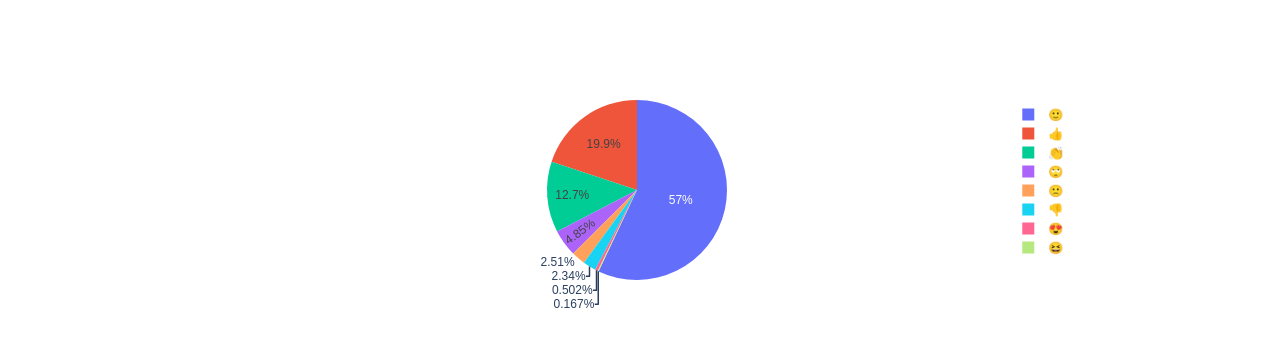

In [18]:
fig = go.Figure(data=[go.Pie(labels=labels, values=counts)])
fig.show()
fig.write_image("pie_chart.png")

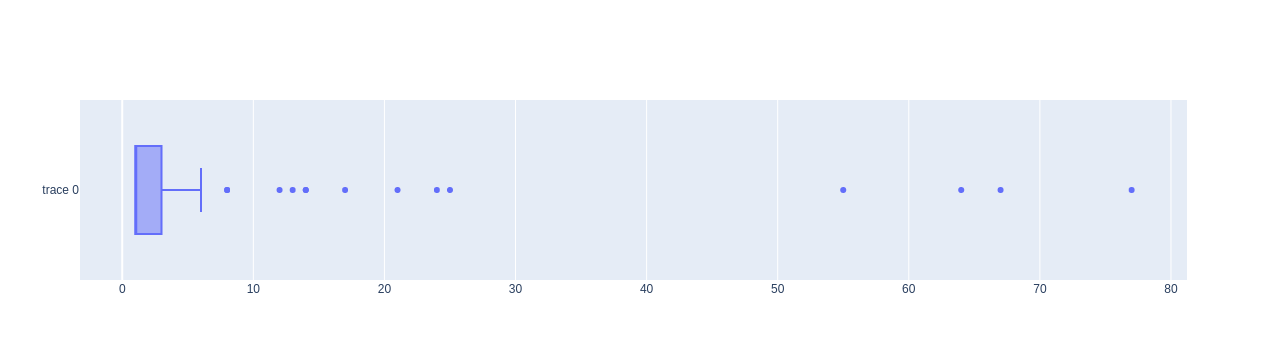

In [75]:
fig = go.Figure(data=[go.Box(x=data.userId.value_counts().values.tolist())])
fig.show()
fig.write_image("pie_chart.png")

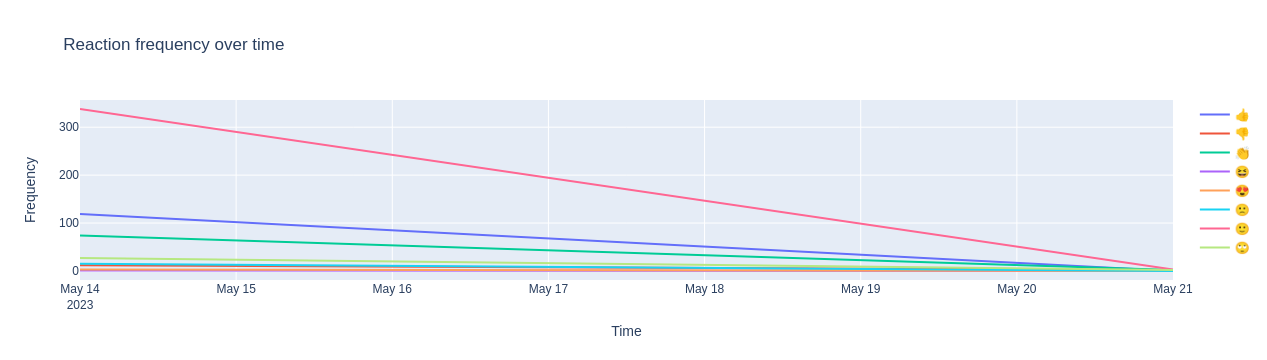

In [21]:
data.index = pd.to_datetime(data.index)

# resample the data into weekly bins and then calculate the value counts for each bin
weekly_counts = data.resample('W').reaction.value_counts()
# unstack the hierarchical index produced by value_counts
weekly_counts = weekly_counts.unstack(level=-1, fill_value=0)

fig = go.Figure()
# Loop through each unique reaction
for reaction in weekly_counts.columns:
    fig.add_trace(go.Scatter(x=weekly_counts.index, 
                             y=weekly_counts[reaction], 
                             mode='lines', 
                             name=reaction))
fig.update_layout(title='Reaction frequency over time',
                  xaxis_title='Time',
                  yaxis_title='Frequency')

fig.show()

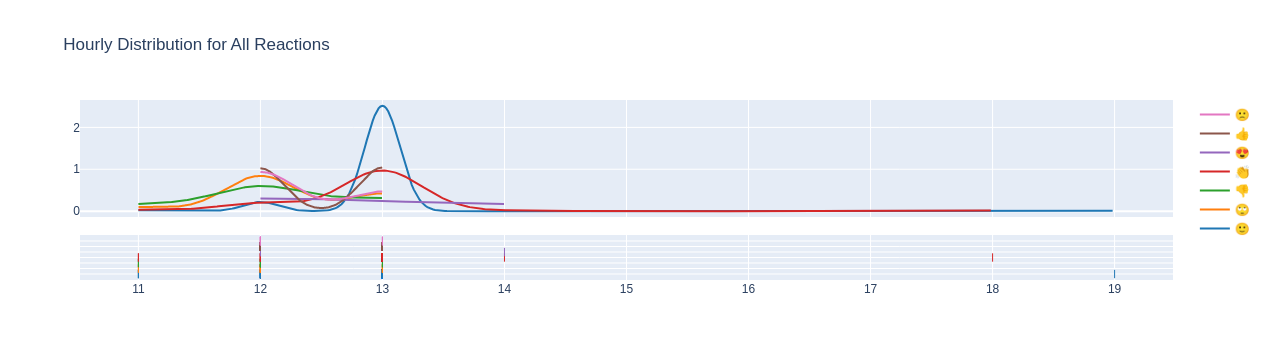

In [70]:
# Convert the index to datetime (if it's not already)
df.index = pd.to_datetime(df.index)

# Create an 'hour' column
df['hour'] = df.index.hour

hist_data = []
group_labels = []
# Get all unique reactions
unique_reactions = df['reaction'].unique()

# Loop through all unique reactions
for reaction in unique_reactions:
    # get the hours where the reaction occurred
    reaction_hours = df[df['reaction'] == reaction].hour

    # Only add to plot if there are at least two unique values
    if len(reaction_hours.unique()) > 1:
        hist_data.append(reaction_hours)
        group_labels.append(reaction)

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2, curve_type='kde', show_hist=False,)
fig.update_layout(title_text='Hourly Distribution for All Reactions')
fig.show()